# Pipeline accident cost prediction

**Objective: Cost study and cost prediction of a pipeline incident**

**Abstract:** The database is listing all accidents reported in the USA from 2010 to 2017 with a wide range of qualitative and quantitative information such as pipeline type, location, operator ID, incurred cost for each incident. Amongst possible use cases of this data set, we are interested in predicting cost of an accident by using other feature variables available. Prior to modelling, some data retreatments are needed to improve the meaning of cost prediction and due to high number of NaN values in the dataset. We employ multiple models and compare their prediction accuracy to find what is the most suitable model to our objective.

The source of the data set: https://www.kaggle.com/usdot/pipeline-accidents

**Notebook Menu:**

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# handle error messages
import warnings
warnings.filterwarnings("ignore")

## 1. Data Analysis

### 1.1. Preliminary Data Preparation

#### - Loading Data
- We first load the data set. The dataset contains 2795 observations (incidents) and 48 columns in both numerical and categorical formats.

In [3]:
path = './database.csv'
df = pd.read_csv(path,delimiter=',')
print(df.shape)
print(df.info())

(2795, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 48 columns):
Report Number                           2795 non-null int64
Supplemental Number                     2795 non-null int64
Accident Year                           2795 non-null int64
Accident Date/Time                      2795 non-null object
Operator ID                             2795 non-null int64
Operator Name                           2795 non-null object
Pipeline/Facility Name                  2674 non-null object
Pipeline Location                       2795 non-null object
Pipeline Type                           2777 non-null object
Liquid Type                             2795 non-null object
Liquid Subtype                          1349 non-null object
Liquid Name                             222 non-null object
Accident City                           2480 non-null object
Accident County                         2720 non-null object
Accident State                   

#### - Columns selection based on NaN ratio
- Since some of the columns contain mostly NaNs, we exclude such columns from the dataframe. As a result, 13 columns are removed.

In [4]:
# Remove columns whose data is more than 90% NaNs
mask = df.apply(lambda x: x.isna().sum()/len(x) < 0.9)
mask = [mask[c] for c in range(len(mask))]
df_reduced = df.loc[:, mask]

# Number of columns reduced from 48 to 35
print(df_reduced.shape)
print("Removed columns are:")
for removed_colum in df.loc[:, np.invert(mask)].columns:
    print (removed_colum)
df_reduced.T

(2795, 35)
Removed columns are:
Liquid Name
Operator Employee Injuries
Operator Contractor Injuries
Emergency Responder Injuries
Other Injuries
Public Injuries
All Injuries
Operator Employee Fatalities
Operator Contractor Fatalities
Emergency Responder Fatalities
Other Fatalities
Public Fatalities
All Fatalities


,0,1,2,3,4,5,6,7,8,9,...,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794
Report Number,20100016,20100254,20100038,20100260,20100030,20100021,20110036,20100255,20100261,20100024,...,20170020,20170022,20170021,20170023,20170026,20170015,20170028,20170027,20170024,20170025
Supplemental Number,17305,17331,17747,18574,16276,17161,18052,18584,18050,18390,...,22026,22029,22027,22030,22044,22020,22046,22045,22032,22040
Accident Year,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2016,2016,2016,2016,2016,2016,2016,2016,2017,2017
Accident Date/Time,1/1/2010 7:15 AM,1/4/2010 8:30 AM,1/5/2010 10:30 AM,1/6/2010 7:30 PM,1/7/2010 1:00 PM,1/8/2010 11:38 PM,1/9/2010 12:15 AM,1/9/2010 1:12 AM,1/10/2010 7:46 PM,1/11/2010 2:30 PM,...,12/21/2016 11:40 AM,12/22/2016 9:25 PM,12/23/2016 3:00 PM,12/24/2016 9:35 AM,12/26/2016 7:20 AM,12/27/2016 8:40 AM,12/28/2016 4:20 PM,12/29/2016 6:40 AM,1/3/2017 10:00 AM,1/9/2017 7:40 AM
Operator ID,32109,15786,20160,11169,300,11169,26041,12624,26041,31684,...,32147,32080,30829,31684,32011,32334,4906,39145,32147,30829
Operator Name,ONEOK NGL PIPELINE LP,PORTLAND PIPELINE CORP,"PETROLOGISTICS OLEFINS, LLC","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","PLAINS PIPELINE, L.P.","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","KINDER MORGAN LIQUID TERMINALS, LLC",MOBIL CORP,"KINDER MORGAN LIQUID TERMINALS, LLC",CONOCOPHILLIPS,...,MARATHON PIPE LINE LLC,"CCPS TRANSPORTATION, LLC",ENTERPRISE CRUDE PIPELINE LLC,PHILLIPS 66 PIPELINE LLC,"HOLLY ENERGY PARTNERS - OPERATING, L.P.",TC OIL PIPELINE OPERATIONS INC,EXXONMOBIL PIPELINE CO,ENBRIDGE STORAGE (CUSHING) L.L.C.,MARATHON PIPE LINE LLC,ENTERPRISE CRUDE PIPELINE LLC
Pipeline/Facility Name,KINDER MORGAN JCT,24-INCH MAIN LINE,NaN,SUPERIOR TERMINAL,RED RIVER EAST,NaN,NaN,HULL STATION,NaN,TANK 1501,...,ELWOOD STATION,LINE 59 KEY STATION,ECHO MANIFOLD,"NT-90, PREDO TO CARSON",RUSSELL STATION,KEYSTONE,BRRF - CHOCTAW ETHANE/PROPANE MIX SYSTEM,CUSHING CENTRAL TERMINAL,MIDLAND STATION,MARSHALL STATION
Pipeline Location,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,...,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE
Pipeline Type,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,UNDERGROUND,UNDERGROUND,TANK,ABOVEGROUND,ABOVEGROUND,TANK,...,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,TANK,UNDERGROUND,ABOVEGROUND
Liquid Type,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,CRUDE OIL,CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",...,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",CRUDE OIL


#### - Shutdown Duration column creation (in hours)
- Using 'Shutdown Date/Time' and 'Restart Date/Time' columns, we create a new column that shows how long the pipeline was shutdown for each accident.
- 1283 cases of accidents, out of 2795, caused a pipeline shutdown in the US between 2010 and 2017.

In [5]:
df_reduced['Shutdown Duration'] = (pd.to_datetime(df_reduced['Restart Date/Time']) - pd.to_datetime(df_reduced['Shutdown Date/Time']))\
.astype('timedelta64[h]')
df = df_reduced.fillna({'Shutdown Duration': 0})  # Convert NaNs into 0
print(df.shape)

# Non null Shutdown Durations
(df['Shutdown Duration']!=0).sum()

(2795, 36)


1283

### 1.2. Data visualization
- In this part, we visualize the data in order to better grab the characteristics of our data set.

#### - Operator ID and Operator Name

- There are 213 different pipeline operators
- Some Operator IDs have multiple Operator Names, which means that there were company name changes due to M&A, etc over the years.

In [6]:
print("Number of distinct Operator ID:", len(df['Operator ID'].unique()))
print("Number of distinct Operator Name:", len(df['Operator Name'].unique()))

Number of distinct Operator ID: 213
Number of distinct Operator Name: 229


#### - Top 10 largest accidents in terms of All Costs

- From the statistics of All Costs, we can see that the cost of the worst accident during 2010-2017 is almost 6 times as high as the cost of the second-worst accident, which largely contributes to the high standard deviation of the values ($std = 16578300$).

In [7]:
# Statistics of All Costs
print("Statistics of All Costs:\n", df['All Costs'].describe())
print("\nTop 10 largest accidents in terms of All Costs and its operator:\n"\
      , df.loc[:,['All Costs','Operator Name', 'Accident Date/Time']].sort_values(by='All Costs', ascending=False).head(10).reset_index())

Statistics of All Costs:
 count    2.795000e+03
mean     8.340332e+05
std      1.657830e+07
min      0.000000e+00
25%      5.039500e+03
50%      2.312900e+04
75%      1.172325e+05
max      8.405261e+08
Name: All Costs, dtype: float64

Top 10 largest accidents in terms of All Costs and its operator:
    index  All Costs                         Operator Name   Accident Date/Time
0    194  840526118  ENBRIDGE ENERGY, LIMITED PARTNERSHIP    7/25/2010 5:58 PM
1   2103  142931884                 PLAINS PIPELINE, L.P.   5/19/2015 10:57 AM
2    523  135000000                EXXONMOBIL PIPELINE CO    7/1/2011 10:40 PM
3   1173   91300000             MOBIL  PIPE  LINE COMPANY    3/29/2013 2:37 PM
4   2675   66234072                  COLONIAL PIPELINE CO    9/9/2016 11:10 AM
5    241   47393566  ENBRIDGE ENERGY, LIMITED PARTNERSHIP    9/9/2010 11:30 AM
6    457   35728903                MARATHON PIPE LINE LLC    4/13/2011 6:58 PM
7    160   32233740                  CHEVRON PIPE LINE CO    6/12/2

#### - Top 10 operators in terms of the number (frequency) of incidents

In [8]:
df_count = df.groupby('Operator ID').size().nlargest(10).reset_index()
df_count = df_count.rename(columns={0:'Number of Incidents'})
name = []
for id in df_count['Operator ID']:
    name.append(" or ".join(df['Operator Name'].loc[df['Operator ID'] == id].unique()))
df_name = pd.DataFrame({'Operator Name': name})
pd.concat([df_count, df_name], axis=1).ix[:,['Number of Incidents', 'Operator Name','Operator ID']]

,Number of Incidents,Operator Name,Operator ID
0,201,"TEPPCO CRUDE PIPELINE, LLC or ENTERPRISE CRUDE...",30829
1,180,SUNOCO PIPELINE L.P.,18718
2,156,"PLAINS PIPELINE, L.P.",300
3,155,ENTERPRISE PRODUCTS OPERATING LLC,31618
4,140,"MAGELLAN PIPELINE COMPANY, LP",22610
5,136,COLONIAL PIPELINE CO,2552
6,115,"BUCKEYE PARTNERS, LP",1845
7,114,CONOCOPHILLIPS or PHILLIPS 66 PIPELINE LLC,31684
8,87,"KINDER MORGAN LIQUID TERMINALS, LLC",26041
9,87,MARATHON PIPE LINE LLC,32147


#### - Top 10 operators in terms of the total amount of All Costs thoughout 2010-2017

In [9]:
df_sum = df.groupby('Operator ID')['All Costs'].agg('sum').nlargest(10).reset_index()
name=[]
for id in df_sum['Operator ID']:
    name.append(" or ".join(df['Operator Name'].loc[df['Operator ID'] == id].unique()))
df_name = pd.DataFrame({'Operator Name': name})
pd.concat([df_sum, df_name], axis=1).ix[:,['All Costs', 'Operator Name','Operator ID']]

,All Costs,Operator Name,Operator ID
0,918465669,"ENBRIDGE ENERGY, LIMITED PARTNERSHIP",11169
1,169708804,"PLAINS PIPELINE, L.P.",300
2,148971955,EXXONMOBIL PIPELINE CO,4906
3,108248631,COLONIAL PIPELINE CO,2552
4,102672298,CHEVRON PIPE LINE CO,2731
5,91872625,EXXONMOBIL PIPELINE CO or MOBIL PIPE LINE CO...,12628
6,70475582,MARATHON PIPE LINE LLC,32147
7,50307083,WEST SHORE PIPELINE CO,22430
8,48836519,ALYESKA PIPELINE SERVICE CO,26149
9,48271931,"SHELL PIPELINE CO., L.P.",31174


#### - Distribution of Liquid Ignition and Liquid Explosion

In [10]:
print(pd.crosstab(df['Liquid Ignition'], df['Liquid Explosion']))

Liquid Explosion    NO  YES
Liquid Ignition            
NO                2700    0
YES                 80   15


#### - Distribution of Cause Categories

- Material/Weld/Equipment Failure was the cause of more than half of the accidents

In [11]:
print(df['Cause Category'].value_counts(), "\n")
print(df['Cause Category'].describe())

MATERIAL/WELD/EQUIP FAILURE    1435
CORROSION                       592
INCORRECT OPERATION             378
ALL OTHER CAUSES                118
NATURAL FORCE DAMAGE            118
EXCAVATION DAMAGE                97
OTHER OUTSIDE FORCE DAMAGE       57
Name: Cause Category, dtype: int64 

count                            2795
unique                              7
top       MATERIAL/WELD/EQUIP FAILURE
freq                             1435
Name: Cause Category, dtype: object


#### - Distribution of Pipeline Types

In [12]:
print(df["Pipeline Type"].value_counts(), "\n")
print(df['Pipeline Type'].describe())

ABOVEGROUND        1475
UNDERGROUND         985
TANK                301
TRANSITION AREA      16
Name: Pipeline Type, dtype: int64 

count            2777
unique              4
top       ABOVEGROUND
freq             1475
Name: Pipeline Type, dtype: object


Text(0.5,1,'Pipeline Type')

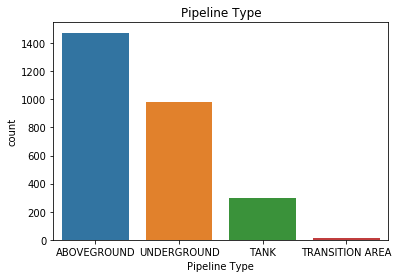

In [13]:
sns.countplot(df['Pipeline Type'])
plt.title('Pipeline Type')

#### - Distribution of Liquid Types

- Majority of liquid types in oil transportation are CRUDE OIL and REFINED AND/OR PETROLEUM PRODUCT.

In [14]:
print(df["Liquid Type"].value_counts(), "\n")
print(df["Liquid Type"].describe())

CRUDE OIL                                               1398
REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID       939
HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS               418
CO2 (CARBON DIOXIDE)                                      38
BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)       2
Name: Liquid Type, dtype: int64 

count          2795
unique            5
top       CRUDE OIL
freq           1398
Name: Liquid Type, dtype: object


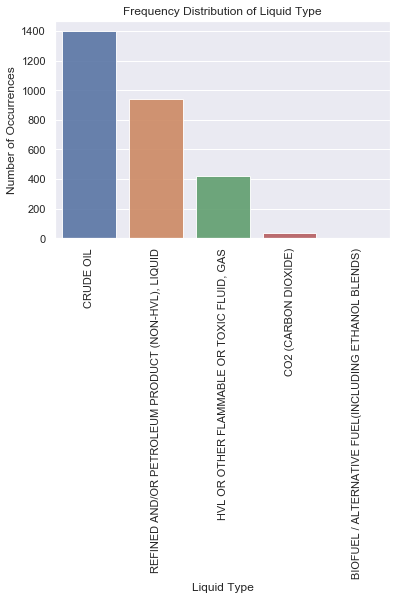

In [15]:
Liquid_Type_count = df['Liquid Type'].value_counts()
sns.set(style="darkgrid")
sns.barplot(Liquid_Type_count.index, Liquid_Type_count.values, alpha=0.9, errwidth=0.1)
plt.title('Frequency Distribution of Liquid Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Liquid Type', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### - Distribution of Net Barrels Loss
- Net Barrels Loss is less than 10 in more than 85% of cases, whereas a bunch of outliers exhibits extreme values (maximum >30000).

2388


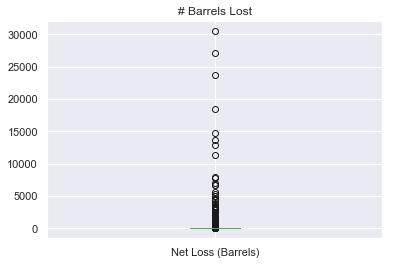

In [16]:
df.boxplot(column='Net Loss (Barrels)')
plt.title('# Barrels Lost')
print((df['Net Loss (Barrels)']<10).sum())

#### - Distribution of Shutdown Duration
- In most cases, the pipeline was recovered within 24 hours (75% percentile value is 18 hours).
- However, there was an accident in 2012 that took more than 2 years to restart the pipeline.

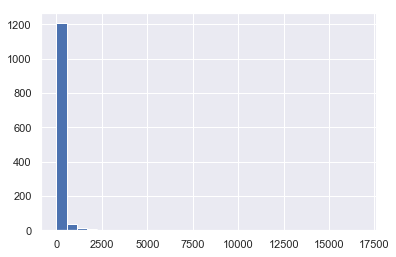

The case that took more than 2 years to restart the pipeline:


,Shutdown Duration,Accident Date/Time,Restart Date/Time,Pipeline Type,Operator Name
974,16746.0,10/7/2012 5:36 PM,9/5/2014 12:00,TANK,EXXONMOBIL PIPELINE CO


In [17]:
df['Shutdown Duration'].describe(), df['Shutdown Duration'].loc[df['Shutdown Duration'] != 0].hist(bins=30)
plt.show()
print("The case that took more than 2 years to restart the pipeline:")
df.loc[:,['Shutdown Duration', 'Accident Date/Time', 'Restart Date/Time','Pipeline Type', 'Operator Name']].loc[df['Shutdown Duration'] == df['Shutdown Duration'].max()]

#### - Yearly Analysis of All Costs
- The level of the Total costs in 2010 is exceptionally high due to the largest accidents in our data set happened on 25th July 2010 by ENBRIDGE ENERGY, LIMITED PARTNERSHIP.
- Number of accident is relatively stable year-on-year.
- Since the last data (accident) is recorded on 9th January 2017, we have only two observations in 2017.

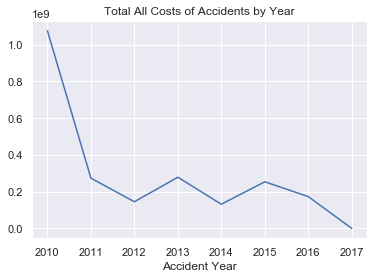

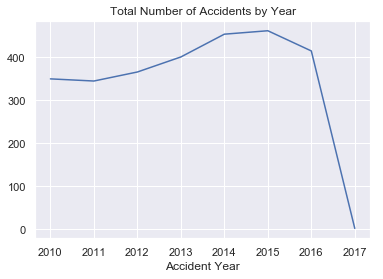

In [18]:
df.groupby(['Accident Year'])['All Costs'].sum().plot(title='Total All Costs of Accidents by Year')
plt.show()
df.groupby(['Accident Year'])['All Costs'].count().plot(title='Total Number of Accidents by Year')
plt.show()

#### - All Cost per Liquid Ignition/Explosion
- Ignition or explosion of a liquid seems not lead to higher costs

In [19]:
print("Mean All Costs grouped by:")
print(df.groupby(['Liquid Ignition'])['All Costs'].mean())
print(df.groupby(['Liquid Explosion'])['All Costs'].mean())
print("\nMaximum All Costs grouped by:")
print(df.groupby(['Liquid Ignition'])['All Costs'].max())
print(df.groupby(['Liquid Explosion'])['All Costs'].max())

Mean All Costs grouped by:
Liquid Ignition
NO     842947.114444
YES    580691.726316
Name: All Costs, dtype: float64
Liquid Explosion
NO     8.324311e+05
YES    1.130972e+06
Name: All Costs, dtype: float64

Maximum All Costs grouped by:
Liquid Ignition
NO     840526118
YES     10262149
Name: All Costs, dtype: int64
Liquid Explosion
NO     840526118
YES      6910591
Name: All Costs, dtype: int64


#### - All Cost per Pipeline Type
- Underground pipeline type rank second in number of accident but rank first in terms of cost, far ahead of other types. Black error bars are confidence intervals for each type of pipeline. If there are outliers, they stand in underground pipeline category

Text(0.5,1,'Total costs per Pipeline Type')

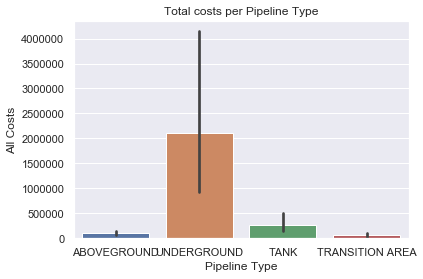

In [20]:
df_PipeLine_Type_All_Cost = df[['Pipeline Type','All Costs']]
sns.barplot(x='Pipeline Type', y="All Costs",  data=df_PipeLine_Type_All_Cost)
plt.title('Total costs per Pipeline Type')

### 1.3. Outliers identification and costs structure plots
- 5 outliers identified as per this plot

(2795, 36)


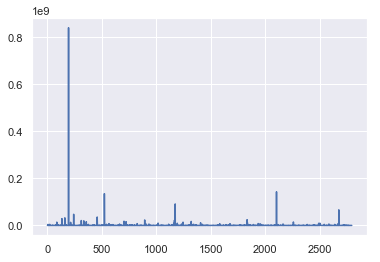

In [21]:
df['All Costs'].plot()
print(df.shape)

- Mean of accident costs is less than a million dollar. Lets focus on accident cost structure of top 25 (except outlier #1 for plot scale reason):

Text(0.5,0,'Index')

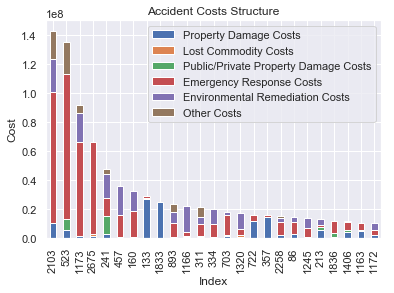

In [22]:
b = df['All Costs'].sort_values(ascending=False) [:30]
top25 = df.iloc[b.index[1:26], 28:-2]
top25.plot.bar(stacked=True)
plt.title('Accident Costs Structure')
plt.ylabel('Cost', fontsize=12)
plt.xlabel('Index', fontsize=12)

- Emergency Response Costs represent the major part of costs structure of top 25 accidents, followed by Environmental remediation costs. Accident 1 is excluded of this graph for scaling matter; its' main costs were Environmental Remediation Costs and Emergency Response Costs respectively.

- The below graph shows the sum of costs categories of all accidents.

- The 3 main costs categories are Environmental Remediation Costs, Emergency Response Costs and Property Damage Costs.

In [23]:
print('Property Damage Costs:                ', "{:,}".format(df['Property Damage Costs'].sum()))
print('Environmental Remediation Costs:      ', "{:,}".format(df['Environmental Remediation Costs'].sum()))
print('Emergency Response Costs:             ', "{:,}".format(df['Emergency Response Costs'].sum()))
print('Lost Commodity Costs:                 ', "{:,}".format(df['Lost Commodity Costs'].sum()))
print('Public/Private Property Damage Costs: ', "{:,}".format(df['Public/Private Property Damage Costs'].sum()))
print('All Costs:                            ', "{:,}".format(df['All Costs'].sum()))

Property Damage Costs:                 313,081,992.0
Environmental Remediation Costs:       1,011,149,910.0
Emergency Response Costs:              814,084,371.0
Lost Commodity Costs:                  27,366,589.0
Public/Private Property Damage Costs:  69,964,627.0
All Costs:                             2,331,122,923


## 2. New Dataset for Machine Learning and Correlation Matrix

### 2.1. Column selection
- Before going to automated feature selection, we manually select maximum number of possible features (columns) that can affect the cost.

- We have selected 14 (+ 'All Costs') features out of 34 columns. For example, we ignore 'Liquid Subtype' because 'Liquid Type' should explain similar impact to the cost, and other columns because of similar reasons. In other words, we select **maximum number of the variables** that avoid multi-collinearity problem.

- Later on, we become further selective on features to avoid the curse of dimensionality, and choose 8 most intuitive features instead of 13 to make cost prediction:
Operator ID, Pipeline Type, Liquid Type, Cause Category, Net Loss (Barrels), Liquid Ignition, Liquid Explosion, Shutdown duration. **We name this dataset as X_intuitive.**

In [24]:
# Select columns to be used for prediction
s = pd.Series([34,2,4,7,8,9,13,14,15,16,22,23,21,35, 27])

# For X_intuitive dataset
intuitive = pd.Series([4,8,9,16,21,22,23,35])
features_intuitive = df.columns[intuitive]

# Highlight the selected columns
for col in range(len(df.columns)):
    if col in list(s):
        print("\033[31m" + str(col), df.columns[col] + "\033[0m")
    else:
        print(col, df.columns[col])

0 Report Number
1 Supplemental Number
2 Accident Year
3 Accident Date/Time
4 Operator ID
5 Operator Name
6 Pipeline/Facility Name
7 Pipeline Location
8 Pipeline Type
9 Liquid Type
10 Liquid Subtype
11 Accident City
12 Accident County
13 Accident State
14 Accident Latitude
15 Accident Longitude
16 Cause Category
17 Cause Subcategory
18 Unintentional Release (Barrels)
19 Intentional Release (Barrels)
20 Liquid Recovery (Barrels)
21 Net Loss (Barrels)
22 Liquid Ignition
23 Liquid Explosion
24 Pipeline Shutdown
25 Shutdown Date/Time
26 Restart Date/Time
27 Public Evacuations
28 Property Damage Costs
29 Lost Commodity Costs
30 Public/Private Property Damage Costs
31 Emergency Response Costs
32 Environmental Remediation Costs
33 Other Costs
34 All Costs
35 Shutdown Duration


In [25]:
df_selected = df[df.columns[s[:,]]].copy()
print(df_selected.shape)

(2795, 15)


#### - Data replacement between Pipeline Type and Pipeline Location
- Because all the observations that have NaN in Pipeline Type are Offshore-located. We replace those NaN type with the value 'OFFSHORE'.

In [26]:
# There are 18 NaNs in Pipeline Type column
print('pipeline type nans: ', df_selected["Pipeline Type"].isna().sum())

# All of those pipelines are located offshore 
print(sum(df_selected['Pipeline Location'][df_selected["Pipeline Type"].isna()]=='OFFSHORE'))  # Count the number of Offshore pipelines out of the 18 observations
print(df_selected["Pipeline Location"].value_counts())

# So We replace Pipeline Type = 'NaN' with 'Offshore'
df_selected["Pipeline Type"][df_selected["Pipeline Type"].isna()]='OFFSHORE'
df_selected["Pipeline Type"].value_counts()

# And we delete the column Pipeline location
df_selected2 = df_selected.drop(columns=['Pipeline Location'])

pipeline type nans:  18
18
ONSHORE     2777
OFFSHORE      18
Name: Pipeline Location, dtype: int64


#### - Data replacement within Public Evacuations column
- We replace NaN type with the value 0.

In [27]:
df_selected2['Public Evacuations'].describe()
df_selected2 = df_selected2.fillna({'Public Evacuations': 0})

#### - Creation of Log All Cost
- Because of some relatively high values in costs to predict (Y variable) compared to it's mean, we create a 'Log All Cost' column to reduce extrem values and also increase correlation with explanatory variables.
- The histogram of Log All Cost seems to be a Gaussian distribution.

count    2795.000000
mean       10.006837
std         2.629996
min         0.000000
25%         8.525062
50%        10.048843
75%        11.671913
max        20.549539
Name: Log All Costs, dtype: float64


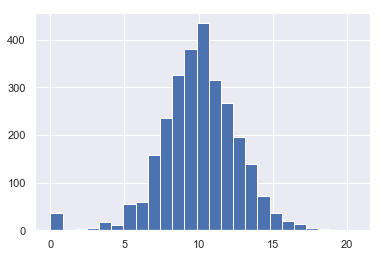

In [28]:
# Take logarithm of All Cost
LogAllCost = np.log(df_selected2['All Costs'])
LogAllCost = LogAllCost.replace([np.inf, -np.inf], np.nan).fillna(0)  # Replace -inf with 0
df_selected2['Log All Costs'] = LogAllCost

print(df_selected2['Log All Costs'].describe())
df_selected2['Log All Costs'].hist(bins=25)

In [29]:
print(df_selected2.shape)
df_selected2.head()

(2795, 15)


,All Costs,Accident Year,Operator ID,Pipeline Type,Liquid Type,Accident State,Accident Latitude,Accident Longitude,Cause Category,Liquid Ignition,Liquid Explosion,Net Loss (Barrels),Shutdown Duration,Public Evacuations,Log All Costs
0,1627,2010,32109,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",KS,38.67070,-97.78123,INCORRECT OPERATION,NO,NO,21.0,0.0,0.0,7.394493
1,4008,2010,15786,ABOVEGROUND,CRUDE OIL,ME,43.94028,-70.49336,MATERIAL/WELD/EQUIP FAILURE,NO,NO,0.0,0.0,0.0,8.296048
2,200,2010,20160,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",LA,30.18240,-93.35240,MATERIAL/WELD/EQUIP FAILURE,NO,NO,2.0,0.0,0.0,5.298317
3,11540,2010,11169,UNDERGROUND,CRUDE OIL,WI,46.68930,-92.06120,NATURAL FORCE DAMAGE,NO,NO,0.0,0.0,0.0,9.353575
4,29650,2010,300,UNDERGROUND,CRUDE OIL,TX,33.58266,-96.64881,EXCAVATION DAMAGE,NO,NO,2.0,0.0,0.0,10.297217


#### - Correlation matrix
- 'Log All Costs' are slightly correlated to Net loss (Barrels) and to shutdow Duration, but significantly more than 'All costs'. No strong correlation can be identified among the quantitative variables. We have at least orthogonality but we expect high error rate in our prediction model and/or weak R² if the regression is made only on these quantitative variables.
- Increasing number of outliers and exclude them from dataset tends to strengthen correlation.

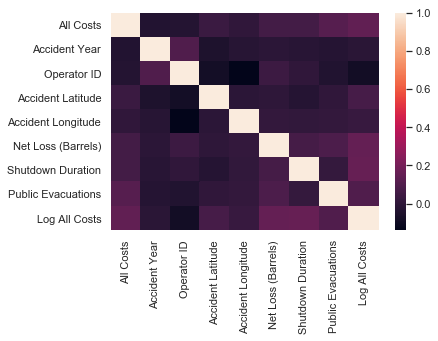

In [30]:
corr = df_selected2.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [31]:
df_selected2.cov() # Covariance matrix is not easily readable

,All Costs,Accident Year,Operator ID,Accident Latitude,Accident Longitude,Net Loss (Barrels),Shutdown Duration,Public Evacuations,Log All Costs
All Costs,2.748400e+14,-1.144180e+06,-6.160399e+09,3.315894e+06,1.326289e+06,1.216508e+09,6.666732e+08,3.236382e+07,6.474402e+06
Accident Year,-1.144180e+06,3.889186e+00,2.380026e+03,-5.218795e-01,-5.867873e-01,-1.562249e+01,-2.381257e+01,-8.956267e-01,-6.814515e-02
Operator ID,-6.160399e+09,2.380026e+03,1.545291e+08,-5.718499e+03,-2.146652e+04,5.834308e+05,3.108264e+04,-7.859723e+03,-2.738499e+03
Accident Latitude,3.315894e+06,-5.218795e-01,-5.718499e+03,3.195188e+01,-7.461077e-01,-1.181240e+01,-8.732440e+01,5.702388e-01,1.038993e+00
Accident Longitude,1.326289e+06,-5.867873e-01,-2.146652e+04,-7.461077e-01,1.519902e+02,2.109175e+02,7.989032e+01,2.664479e+00,8.272245e-01
Net Loss (Barrels),1.216508e+09,-1.562249e+01,5.834308e+05,-1.181240e+01,2.109175e+02,1.404271e+06,4.949745e+04,1.771966e+03,4.871775e+02
Shutdown Duration,6.666732e+08,-2.381257e+01,3.108264e+04,-8.732440e+01,7.989032e+01,4.949745e+04,3.929177e+05,1.966889e+02,2.618888e+02
Public Evacuations,3.236382e+07,-8.956267e-01,-7.859723e+03,5.702388e-01,2.664479e+00,1.771966e+03,1.966889e+02,2.757102e+02,4.361056e+00
Log All Costs,6.474402e+06,-6.814515e-02,-2.738499e+03,1.038993e+00,8.272245e-01,4.871775e+02,2.618888e+02,4.361056e+00,6.916880e+00


In [32]:
newdf = df_selected2.copy()

### 2.2. One-hot encoding & Value replacement

In [33]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 15 columns):
All Costs             2795 non-null int64
Accident Year         2795 non-null int64
Operator ID           2795 non-null int64
Pipeline Type         2795 non-null object
Liquid Type           2795 non-null object
Accident State        2783 non-null object
Accident Latitude     2795 non-null float64
Accident Longitude    2795 non-null float64
Cause Category        2795 non-null object
Liquid Ignition       2795 non-null object
Liquid Explosion      2795 non-null object
Net Loss (Barrels)    2795 non-null float64
Shutdown Duration     2795 non-null float64
Public Evacuations    2795 non-null float64
Log All Costs         2795 non-null float64
dtypes: float64(6), int64(3), object(6)
memory usage: 327.6+ KB


In [34]:
# Extract names of the categorical columns
categorical_columns = [col for col in newdf.columns if newdf[col].dtype == 'object']
# Add Operator ID column manually
categorical_columns.append('Operator ID')
categorical_columns

['Pipeline Type',
 'Liquid Type',
 'Accident State',
 'Cause Category',
 'Liquid Ignition',
 'Liquid Explosion',
 'Operator ID']

#### - Implementation of One-Hot encoding
- We use a for-loop to do one-hot encoding. Categorical data will be converted into multiple dummy variable columns.
- In order to avoid the problem of **multicollinearity** among dummies of each categorical data (**'dummy variable trap'**), we use the option, "drop_first=True", of the function pd.get_dummies(). This option enables to drop first dummy column for each categorical data so that the dropped column's value can be described by setting the rest of the dummies as all 0.
- We will also need to be careful about **curse of dimensionality**. Note that now we have 2795 obervations. If we have too many explanatory variables compared to the number of observation, the curse of dimensionality will damage the quality of our prediction. Especially, one-hot encoding of Operator ID will significantly increase the dimensionality.

In [35]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

# Loop for one-hot encoding
for col in categorical_columns:
    dum = pd.get_dummies(newdf[col], prefix=col, drop_first=True)
    newdf = pd.concat([newdf, dum], axis=1)
    newdf = newdf.drop([col], axis=1)

- Now we have the new dataframe with every categorical data being one-hot format. The encoding enlarged the number of columns.

In [36]:
print(newdf.shape)

(2795, 281)


### 2.3. Feature Selection

- We calculate feature (variable) importance by measuring how much Mean Squared Error (MSE) is increased if we remove one of the features in turn.
- Since we have categorical data whose feature was encoded into multiple dummy columns, we cannot use standard feature importance function in libraries.
- Therefore, we constructed our original function to measure feature importance based on MSE.

In [37]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, explained_variance_score
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
import math
import sklearn.metrics as metrics

- Extract the X and y data from the dataframe

In [38]:
#Erase top 5 outliers:
#dataframe = dataframe.drop(dataframe.index[[194, 2103, 523, 1173, 2675]])
#dataframe = dataframe.dropna(axis=0).copy()
dataframe = newdf.copy()
print(dataframe.shape)
# Extract the X and y data from the dataframe
X = dataframe.drop(['All Costs', 'Log All Costs'], axis=1)
X_original = X
print("Shape of X:", X.shape)
y = dataframe['Log All Costs']

(2795, 281)
Shape of X: (2795, 279)


In [39]:
features = [col for col in df_selected2.columns]
features.remove('All Costs')
features.remove('Log All Costs')
columns = [col for col in newdf.columns]
columns.remove('All Costs')
columns.remove('Log All Costs')

In [40]:
# Identify sets of columns to be deleted for each feature
# This will give a dictionary with key = feature & value = names of the dummy columns of the corresponding feature
import re
dic = {}
for feat in features:
    l = []
    for col in columns:
        exists = re.search(feat, col)
        if exists:
            l.append(col)
    if not l:  # If the list is empty
        dic[feat] = [feat]
    else:
        dic[feat] = l

#### - Definition of the Variable Importance Function:

In [41]:
# Run the model of our choice on the dataset without one of the features in turn,
# and calculate the gap (i.e. importance) between the MSE on such dataset and
# the MSE on the dataset with all the features

def ext0(imp):
    return imp[0]
def ext1(imp):
    return imp[1]

def Variable_Importance_Function(model, n_epoch, X, y, features, dic):
    model_ = model
    # Calculate MSE in case of using all the features
    model.fit(X, y)
    y_hat = model.predict(X)
    mse = metrics.mean_squared_error(y, y_hat)

    # In order to get a robust result, we calculate the importance 'n_epoch' times and take average
    importance_set = []
    for epoch in range(n_epoch):
        importance = []
        for feat in features:
            X_ = X.copy()
            for col in dic[feat]:
                X_ = X_.drop(col, axis=1)
            model_.fit(X_, y)
            y_hat_ = model_.predict(X_)
            mse_ = metrics.mean_squared_error(y, y_hat_)
            importance.append((feat, mse_ - mse))
        importance_set.append(importance)

    feature_names = list(map(ext0, importance))
    value_list=[]
    for i in range(len(importance_set)):
        values = list(map(ext1, importance_set[i]))
        value_list.append(values)
    value_list

    # Take the average of the importance values
    importance_mean = np.mean(value_list, axis=0)
    importance_mean

    importance_list = []
    for i in range(len(importance)):
        importance_list.append((feature_names[i], importance_mean[i]))
    
    # Sort the importance
    criteria = lambda e: e[1]
    importance_list.sort(key=criteria, reverse=True)
    
    return importance_list

#### - Implementation of Variable Importance Function using **Random Forest** (It may take about a minute)
- From the below result, we found that 'Net Loss (Barrels)' is the most important feature when predicting the cost, followed by 'Pipeline Type' or 'Shutdown Duration'.
- Sometimes, a few featues have negative importance value. This means that inclusion of its feature actually increases the prediction error. These features should be excluded from our feature selection.

In [42]:
# Initialize the result
# Later on, we will take average of importance result based on different models (Random Forest and K-Neighbors)
importance_result = []

In [43]:
# Choose Model and Number of epoch
model = RandomForestRegressor(max_depth=5, criterion='mse', n_estimators=100)
n_epoch = 5

# Run the function
importance_list = Variable_Importance_Function(model, n_epoch, X, y, features, dic)

# Display the result
for i in range(len(importance_list)):
    print(importance_list[i])
    
# Save the result
criteria = lambda e: e[0]
importance_list.sort(key=criteria)
importance_result.append(importance_list)

('Net Loss (Barrels)', 0.3816691961747761)
('Shutdown Duration', 0.27957716780702524)
('Pipeline Type', 0.2747669235062489)
('Liquid Type', 0.1348296358443326)
('Liquid Ignition', 0.12003632516060767)
('Accident Longitude', 0.0164163691199704)
('Cause Category', 0.011731345385828717)
('Accident Year', 0.007480449655386056)
('Accident Latitude', 0.007086304833800394)
('Accident State', 0.0017874338494103803)
('Public Evacuations', -0.0026661680969512604)
('Operator ID', -0.003361432127393371)
('Liquid Explosion', -0.00709899952427957)


#### - Implementation of Variable Importance Function using **K-Neighbors** (It may take about a few minutes)
- From the below result, we found that 'Shutdown Duration' is the most important feature this time when predicting the cost, followed by 'Liquid Ignition' and 'Cause Category'.

In [44]:
# Choose Model and Number of epoch
#model = BaggingRegressor(KNeighborsRegressor(n_neighbors=15, weights='distance'))
n_epoch = 3

# Or alternatively (reduce execution time)
model = KNeighborsRegressor(n_neighbors=15, weights='distance')

# Run the function
importance_list = Variable_Importance_Function(model, n_epoch, X, y, features, dic)

# Display the result
for i in range(len(importance_list)):
    print(importance_list[i])
    
# Save the result
criteria = lambda e: e[0]
importance_list.sort(key=criteria)
importance_result.append(importance_list)

('Accident Year', 0.02727964923144151)
('Pipeline Type', 0.009350463909276428)
('Net Loss (Barrels)', 0.008456189446807927)
('Shutdown Duration', 0.00653269558532214)
('Cause Category', 0.0024637373041972183)
('Accident State', 0.0023609321846420617)
('Accident Longitude', 0.0022486306025761432)
('Accident Latitude', 0.00036075146267646775)
('Operator ID', 0.0)
('Liquid Type', 0.0)
('Liquid Ignition', 0.0)
('Liquid Explosion', 0.0)
('Public Evacuations', 0.0)


#### - Aggregation of the two results by taking average

In [45]:
feature_names = list(map(ext0, importance_list))
value_list=[]
for i in range(len(importance_result)):
    values = list(map(ext1, importance_result[i]))
    value_list.append(values)

# Take the average of the importance values
importance_mean = np.mean(value_list, axis=0)
importance_mean

final_result = []
for i in range(len(importance_mean)):
    final_result.append((feature_names[i], importance_mean[i]))
final_result
    
# Sort the importance
criteria = lambda e: e[1]
final_result.sort(key=criteria, reverse=True)

# Display the result
for i in range(len(final_result)):
    print(final_result[i])

('Net Loss (Barrels)', 0.19506269281079203)
('Shutdown Duration', 0.1430549316961737)
('Pipeline Type', 0.14205869370776264)
('Liquid Type', 0.0674148179221663)
('Liquid Ignition', 0.06001816258030383)
('Accident Year', 0.017380049443413783)
('Accident Longitude', 0.00933249986127327)
('Cause Category', 0.007097541345012968)
('Accident Latitude', 0.003723528148238431)
('Accident State', 0.002074183017026221)
('Public Evacuations', -0.0013330840484756302)
('Operator ID', -0.0016807160636966856)
('Liquid Explosion', -0.003549499762139785)


#### - Select Features based on the Importance
- Based on the final result above, we choose features that have relatively importance.

In [46]:
# Decide on how many features to include in our models
n_features = 8

feature_names = list(map(ext0, final_result))
features_to_delete = list(map(ext0, final_result))
del features_to_delete[:n_features]
#print("Features to be deleted:",features_to_delete)

print("We have selected the highlighted", n_features, "features:")
for i in range(len(feature_names)):
    if feature_names[i] not in features_to_delete:
        print("\033[31m" + "Importance Rank", str(i+1), feature_names[i] + "\033[0m")
    else:
        print("Importance Rank", i, feature_names[i])

We have selected the highlighted 8 features:
Importance Rank 1 Net Loss (Barrels)
Importance Rank 2 Shutdown Duration
Importance Rank 3 Pipeline Type
Importance Rank 4 Liquid Type
Importance Rank 5 Liquid Ignition
Importance Rank 6 Accident Year
Importance Rank 7 Accident Longitude
Importance Rank 8 Cause Category
Importance Rank 8 Accident Latitude
Importance Rank 9 Accident State
Importance Rank 10 Public Evacuations
Importance Rank 11 Operator ID
Importance Rank 12 Liquid Explosion


In [47]:
# Name the X after the Feature Selection as X_FS
X_FS = X

# Remove all the columns in the list of features_to_delete
for feat in features_to_delete:
    for col in dic[feat]:
        X_FS = X_FS.drop(col, axis=1)

# Display new X of our interest (X_FS)
X_FS.T

,0,1,2,3,4,5,6,7,8,9,...,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794
Accident Year,2010.00000,2010.00000,2010.0000,2010.0000,2010.00000,2010.00000,2010.0000,2010.0000,2010.0000,2010.00000,...,2016.000000,2016.000000,2016.000000,2016.000000,2016.00000,2016.000000,2016.000000,2016.000000,2017.000000,2017.000000
Accident Longitude,-97.78123,-70.49336,-93.3524,-92.0612,-96.64881,-97.52554,-95.1201,-94.3805,-95.1201,-95.17611,...,-85.862792,-92.840164,-95.184793,-98.624766,-102.91921,-93.486055,-91.274491,-96.454956,-80.440463,-97.400301
Net Loss (Barrels),21.00000,0.00000,2.0000,0.0000,2.00000,2237.00000,5.0000,0.2400,0.0000,0.00000,...,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,580.000000,0.000000,0.000000,0.000000
Shutdown Duration,0.00000,0.00000,0.0000,0.0000,0.00000,105.00000,0.0000,0.0000,0.0000,0.00000,...,18.000000,4.000000,0.000000,0.000000,2.00000,7.000000,0.000000,0.000000,0.000000,0.000000
Pipeline Type_OFFSHORE,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Pipeline Type_TANK,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,1.0000,0.0000,0.0000,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
Pipeline Type_TRANSITION AREA,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Pipeline Type_UNDERGROUND,0.00000,0.00000,0.0000,1.0000,1.00000,1.00000,0.0000,0.0000,0.0000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000
Liquid Type_CO2 (CARBON DIOXIDE),0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Liquid Type_CRUDE OIL,0.00000,1.00000,0.0000,1.0000,1.00000,1.00000,0.0000,0.0000,0.0000,0.00000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,1.000000


#### - Select features with our intuition
- Also, we make another dataset X_intuitive that we manually chose with intuition.

In [48]:
# Name the X after the Feature Selection as X_FS
X_intuitive = X

featues_non_intuitive = list(set(features) - set(list(features_intuitive)))

# Remove all the columns in the list of features_to_delete
for feat in featues_non_intuitive:
    for col in dic[feat]:
        X_intuitive = X_intuitive.drop(col, axis=1)
list(features_intuitive)

['Operator ID',
 'Pipeline Type',
 'Liquid Type',
 'Cause Category',
 'Net Loss (Barrels)',
 'Liquid Ignition',
 'Liquid Explosion',
 'Shutdown Duration']

#### - Select features using SelectFromModel function
- Lastly, we can also make another set of explanatory variables using SelectFromModel()
- Note that this function reduces the number of variables **regardless of whether it is one of categorical dummy columns or a quantitative variable column**. As a result, we could reduce the number of variables to 113.

(2795, 279)
(2795, 113)


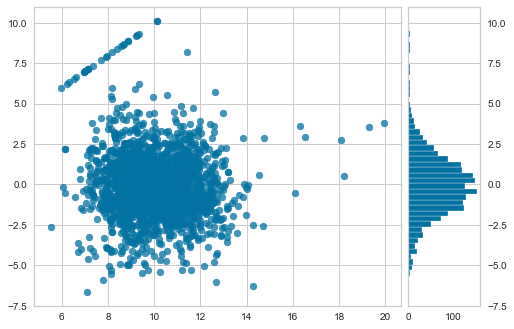

In [49]:
print(X.shape)
model = Ridge(alpha=3.0, fit_intercept=True, max_iter=None, normalize=False, solver='auto', tol=0.001)
visualizer = ResidualsPlot(model)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
visualizer.fit(X_train, y_train)

# Use of SelectFromModel
modela = SelectFromModel(model, prefit=True)
X_new = modela.transform(X)
print(X_new.shape)

## 3. Modelling and regression

### 3.1. Train-Test Split
- We now have 4 different sets of explanatory variables: X_FS, X_intuitive, X_new and X_original
- We split the dataset into traninig set and test set with the ratio of 7:3.

Model Selection Reference: https://scikit-learn.org/stable/model_selection.html

(PCA trial: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)

In [50]:
print(X_FS.shape)
print(X_intuitive.shape)
print(X_new.shape)
print(X_original.shape)

# Choose one of the sets of explanatory variables on which you want to run the models.
#X = X_FS
#X = X_intuitive
#X = X_new
#X = X_original

#print(X.shape)
#print(y.shape)

(2795, 19)
(2795, 230)
(2795, 113)
(2795, 279)


In [51]:
# Create the train and test data 
X1_train, X1_test, y1_train, y1_test = train_test_split(X_FS, y, test_size=0.3, random_state=123)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_intuitive, y, test_size=0.3, random_state=123)
X3_train, X3_test, y3_train, y3_test = train_test_split(X_new, y, test_size=0.3, random_state=123)
X4_train, X4_test, y4_train, y4_test = train_test_split(X_original, y, test_size=0.3, random_state=123)

Set1 = (X1_train, y1_train, X1_test, y1_test)
Set2 = (X2_train, y2_train, X2_test, y2_test)
Set3 = (X3_train, y3_train, X3_test, y3_test)
Set4 = (X4_train, y4_train, X4_test, y4_test)

Sets = (Set1, Set2, Set3, Set4)

#print("Shape of X_train:", X_train.shape)
#print("Shape of X_test:", X_test.shape)
#print("Shape of y_train:", y_train.shape)
#print("Shape of y_test:", y_test.shape)

#### - Reminder of Mean Squared Error (MSE)
- As a reminder, MSE is defined as:
$$MSE = \frac{1}{n}\sum_{i=1}^{n} ( y_i - \hat{y}_i )^2$$

#### - Reminder of R-squared
- As a reminder, R² formula:
$$ R^2 = 1 - \frac{Sum of Squares of Residuals}{Total Sum of Squares} = 1 - \frac{\sum_i ( y_i - \hat{y}_i )^2}{\sum_i (y_i - \bar{y})^2}$$

$$ R^2_{adjusted} = 1 - \frac{\sum_i ( y_i - \hat{y}_i )^2/(N-p-1)}{\sum_i (y_i - \bar{y})^2/(N-1)}$$
- Comparing the definition of MSE and R², we can interpret that **R² is a deviation-normalised version of MSE**.
- Since we have datasets which vary in number of explanatory variables, we want to use **adjusted R-squared**. (Simple R-squared keeps increasing while adding more explanatory variables (columns))

### 3.2. Ridge
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

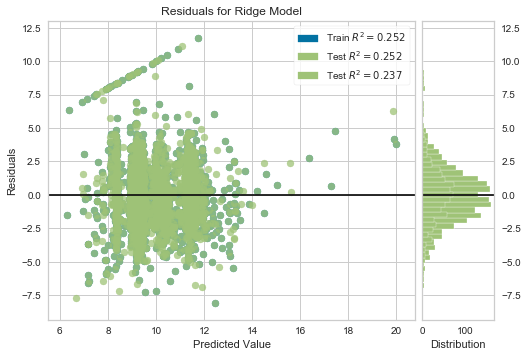

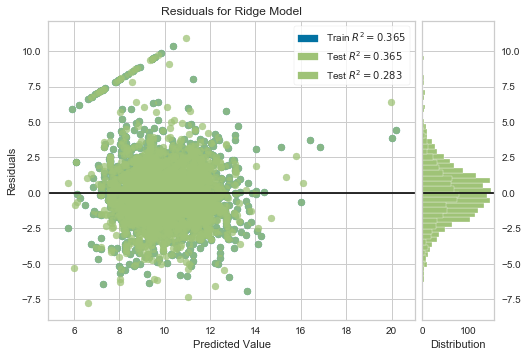

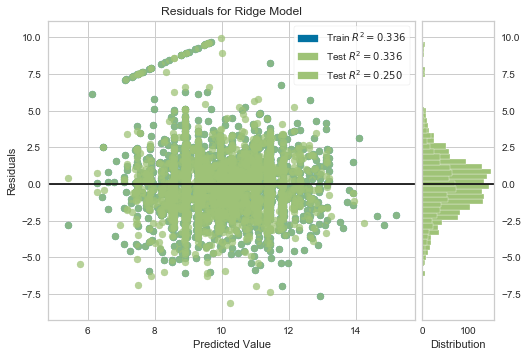

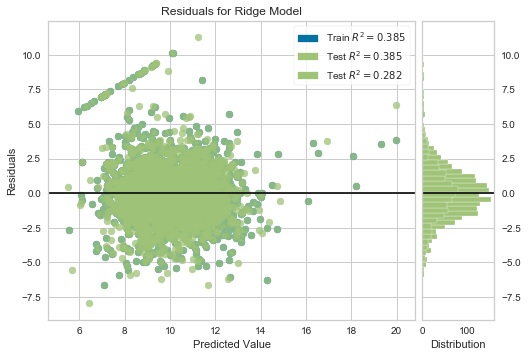

[(0.2521986650110071, 0.2374098634768622), (0.36541436901808566, 0.2832494492836807), (0.336171933046531, 0.25010866557645683), (0.3851827470017382, 0.281544307808943)]
[(0.24485970562836723, 0.2197185172083156), (0.2808029515538305, 0.012110260690336272), (0.29544849571442333, 0.1332290506938908), (0.2828354835252972, -0.07704091244383848)]


In [70]:
# Instantiate the linear model and visualizer
R_sq_list = []
R_adj_list = []

for Set in Sets:

    model = Ridge(alpha=3.0, fit_intercept=True, max_iter=None, normalize=False, solver='auto', tol=0.001)
    visualizer = ResidualsPlot(model)
    visualizer.fit(Set[0], Set[1])  # Fit the training data to the visualizer
    
    R_sq_train = visualizer.score(Set[0], Set[1])
    R_sq_test = visualizer.score(Set[2], Set[3])
    R_adj_train = 1 - (1-R_sq_train)*(len(Set[1])-1)/(len(Set[1])-Set[0].shape[1]-1)
    R_adj_test = 1 - (1-R_sq_test)*(len(Set[3])-1)/(len(Set[3])-Set[2].shape[1]-1)
    
    R_sq_list.append((R_sq_train, R_sq_test))
    R_adj_list.append((R_adj_train, R_adj_test))
    
    g = visualizer.poof()             # Draw/show/poof the data
    model.get_params()

print(R_sq_list)
print(R_adj_list)

In [71]:
ridge_R_sq = pd.DataFrame({ 'X_FS' : R_sq_list[0],
                        'X_intuitive' : R_sq_list[1],
                        'X_new' : R_sq_list[2],
                        'X_original' : R_sq_list[3]})
ridge_R_adj = pd.DataFrame({ 'X_FS' : R_adj_list[0],
                        'X_intuitive' : R_adj_list[1],
                        'X_new' : R_adj_list[2],
                        'X_original' : R_adj_list[3]})
ridge_R_sq.index = ['Train', 'Test']
ridge_R_adj.index = ['Train', 'Test']

print("R-squared:")
display(ridge_R_sq)
print("Adjusted R-squared:")
display(ridge_R_adj)

R-squared:


,X_FS,X_intuitive,X_new,X_original
Train,0.252199,0.365414,0.336172,0.385183
Test,0.237410,0.283249,0.250109,0.281544


Adjusted R-squared:


,X_FS,X_intuitive,X_new,X_original
Train,0.244860,0.280803,0.295448,0.282835
Test,0.219719,0.012110,0.133229,-0.077041


- Playing on penalization doesn't help to solve overfitting results as per the R² difference between train and test sets.
It seems to be a curse of dimensionality problem which leads to overfitting. Employing X_new seems to be an appropriate as per its results

- As per this graph, Ridge model or any linear model won't correctly fit our data. The huge difference of R² between train and test sets indicates the Ridge model is over-fitting
Neither linear nor polynomial model seem adapted to modelize this dataset; we propose to use bagging methodology to try to get better estimated values

- Use of (Bagging) meta-estimators

- The KNeighborsRegressor or random forest regressor use kNN or decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

### 3.3. K-Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [73]:
R_sq_list = []
R_adj_list = []

for Set in Sets:

    # Model creation and fit
    model1 = BaggingRegressor(KNeighborsRegressor(n_neighbors=15, weights='distance'))
    model1.fit(Set[0],Set[1])

    # results of training set
    y2_hat = model1.predict(Set[0])
    mae = metrics.mean_absolute_error(Set[1],y2_hat)
    mse = metrics.mean_squared_error(Set[1],y2_hat)

    # results of test set
    y_hat_test = model1.predict(Set[2])
    mae = metrics.mean_absolute_error(Set[3],y_hat_test)
    mse = metrics.mean_squared_error(Set[3],y_hat_test)
    
    # R-squared
    R_sq_train = model1.score(Set[0], Set[1])
    R_sq_test = model1.score(Set[2], Set[3])
    R_adj_train = 1 - (1-R_sq_train)*(len(Set[1])-1)/(len(Set[1])-Set[0].shape[1]-1)
    R_adj_test = 1 - (1-R_sq_test)*(len(Set[3])-1)/(len(Set[3])-Set[2].shape[1]-1)
    
    R_sq_list.append((R_sq_train, R_sq_test))
    R_adj_list.append((R_adj_train, R_adj_test))

model1.get_params()

{'base_estimator__algorithm': 'auto',
 'base_estimator__leaf_size': 30,
 'base_estimator__metric': 'minkowski',
 'base_estimator__metric_params': None,
 'base_estimator__n_jobs': None,
 'base_estimator__n_neighbors': 15,
 'base_estimator__p': 2,
 'base_estimator__weights': 'distance',
 'base_estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='distance'),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [74]:
kNN_R_sq = pd.DataFrame({ 'X_FS' : R_sq_list[0],
                        'X_intuitive' : R_sq_list[1],
                        'X_new' : R_sq_list[2],
                        'X_original' : R_sq_list[3]})
kNN_R_adj = pd.DataFrame({ 'X_FS' : R_adj_list[0],
                        'X_intuitive' : R_adj_list[1],
                        'X_new' : R_adj_list[2],
                        'X_original' : R_adj_list[3]})
kNN_R_sq.index = ['Train', 'Test']
kNN_R_adj.index = ['Train', 'Test']

print("R-squared:")
display(kNN_R_sq)
print("Adjusted R-squared:")
display(kNN_R_adj)

R-squared:


,X_FS,X_intuitive,X_new,X_original
Train,0.874145,0.837109,0.562842,0.885774
Test,0.240505,0.273467,0.194997,0.238043


Adjusted R-squared:


,X_FS,X_intuitive,X_new,X_original
Train,0.872909,0.815391,0.536024,0.866759
Test,0.222885,-0.001373,0.069528,-0.142254


### 3.4. AdaBoost

In [111]:
model2 = AdaBoostRegressor(n_estimators=100)
scores = cross_val_score(model2, X, y, cv=10) # Cross-Validation
scores.mean() 

0.21210079538389154

### 3.5. Random Forest Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [76]:
R_sq_list = []
R_adj_list = []

for Set in Sets:

    # Model creation and fit
    model3 = RandomForestRegressor(max_depth=3, criterion='mse', n_estimators=100)
    model3.fit(Set[0],Set[1])

    # model results of training set
    y2_hat = model3.predict(Set[0])
    mae = metrics.mean_absolute_error(Set[1],y2_hat)
    mse = metrics.mean_squared_error(Set[1],y2_hat)
    mse_allfeatures = mse

    # model results of test set
    y_hat_test = model3.predict(Set[2])
    mae = metrics.mean_absolute_error(Set[3],y_hat_test)
    mse = metrics.mean_squared_error(Set[3],y_hat_test)

    # R-squared
    R_sq_train = model3.score(Set[0],Set[1])
    R_sq_test = model3.score(Set[2],Set[3])
    R_adj_train = 1 - (1-R_sq_train)*(len(Set[1])-1)/(len(Set[1])-Set[0].shape[1]-1)
    R_adj_test = 1 - (1-R_sq_test)*(len(Set[3])-1)/(len(Set[3])-Set[2].shape[1]-1)
    
    R_sq_list.append((R_sq_train, R_sq_test))
    R_adj_list.append((R_adj_train, R_adj_test))

In [78]:
rf_R_sq = pd.DataFrame({ 'X_FS' : R_sq_list[0],
                        'X_intuitive' : R_sq_list[1],
                        'X_new' : R_sq_list[2],
                        'X_original' : R_sq_list[3]})
rf_R_adj = pd.DataFrame({ 'X_FS' : R_adj_list[0],
                        'X_intuitive' : R_adj_list[1],
                        'X_new' : R_adj_list[2],
                        'X_original' : R_adj_list[3]})
rf_R_sq.index = ['Train', 'Test']
rf_R_adj.index = ['Train', 'Test']

print("R-squared:")
display(rf_R_sq)
print("Adjusted R-squared:")
display(rf_R_adj)

R-squared:


,X_FS,X_intuitive,X_new,X_original
Train,0.335217,0.341348,0.232138,0.344782
Test,0.282261,0.277801,0.150800,0.275107


Adjusted R-squared:


,X_FS,X_intuitive,X_new,X_original
Train,0.328693,0.253527,0.185032,0.235709
Test,0.265610,0.004601,0.018442,-0.086692


### 3.6. Aggregation of the results

In [89]:
R_sq_Table = pd.concat([ridge_R_sq, kNN_R_sq, rf_R_sq], axis=0)
R_sq_Table.reset_index(drop=True)
R_sq_Table.index = ['Ridge (train)', 'Ridge (test)', 'kNN (train)', 'kNN (test)', 'Random Forest (train)', 'Random Forest (test)']
print("R-squared:")
display(R_sq_Table)

R_adj_Table = pd.concat([ridge_R_adj, kNN_R_adj, rf_R_adj], axis=0)
R_adj_Table.reset_index(drop=True)
R_adj_Table.index = ['Ridge (train)', 'Ridge (test)', 'kNN (train)', 'kNN (test)', 'Random Forest (train)', 'Random Forest (test)']
print("Adjusted R-squared:")
display(R_adj_Table)

R-squared:


,X_FS,X_intuitive,X_new,X_original
Ridge (train),0.252199,0.365414,0.336172,0.385183
Ridge (test),0.237410,0.283249,0.250109,0.281544
kNN (train),0.874145,0.837109,0.562842,0.885774
kNN (test),0.240505,0.273467,0.194997,0.238043
Random Forest (train),0.335217,0.341348,0.232138,0.344782
Random Forest (test),0.282261,0.277801,0.150800,0.275107


Adjusted R-squared:


,X_FS,X_intuitive,X_new,X_original
Ridge (train),0.244860,0.280803,0.295448,0.282835
Ridge (test),0.219719,0.012110,0.133229,-0.077041
kNN (train),0.872909,0.815391,0.536024,0.866759
kNN (test),0.222885,-0.001373,0.069528,-0.142254
Random Forest (train),0.328693,0.253527,0.185032,0.235709
Random Forest (test),0.265610,0.004601,0.018442,-0.086692


## 4. Conclusion

- Meta estimator such as randomforestRegressor are more efficient and accurate than simple regressor models. With a R² about 30%, relatively ahead of linear regression models for cost prediction of pipeline accident.

- From the above table, we can confirm that our Feature Selection based on Variable Importance (MSE) works well and efficient as it give stable and better results in both R-squared and adjusted R-squared than other datasets (X_intuitive, X_new or X_original). This means that it could obtain better, or at least the same level of accuracy of, prediction using much smaller number (8, or 19 after the One-Hot encoding) of explanatory variables than other datasets (+100-200 explanatory variables/columns).